In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Any

In [2]:
# Define a class StateNode for representing states in the Markov Random Process (MRP)
class StateNode:
    def __init__(self, state_name: str):
        # Initialize a StateNode with a state name
        self.value = state_name  # Assign the state name
        self.right = None  # Initialize the right neighbor as None
        self.left = None   # Initialize the left neighbor as None
        self.right_reward = 0  # Reward for stepping right
        self.left_reward = 0   # Reward for stepping left

    def __eq__(self, other_state_name) -> bool:
        # Define the equality comparison for StateNode
        return self.value == other_state_name

    def __repr__(self) -> str:
        # Return a string representation of StateNode
        return f"StateNode {self.value}"

In [3]:
# Define a class RandomWalkEnvironment for simulating a random walk environment
class RandomWalkEnvironment:
    def __init__(self):
        # Initialize the state space, state index map, initial state, and nodes
        self.state_space = ["A", "B", "C", "D", "E"]
        self.state_index_map = {
            state: idx + 1 for idx, state in enumerate(self.state_space)
        }
        self.initial_state = "C"
        self.initial_index = self.state_index_map[self.initial_state]
        self.nodes = self.build_environment()  # Build the environment
        self.reset()  # Reset the environment to the initial state

    def step(self, action: int) -> tuple:
        # Simulate a step in the random walk based on the action (0 or 1)
        assert action in [0, 1], "Action should be 0 or 1"

        if action == 0:
            # If the action is 0 (left), update reward and next index accordingly
            reward = self.current_state.left_reward
            next_index = self.state_index_map[self.current_state.value] - 1
            self.current_state = self.current_state.left
        else:
            # If the action is 1 (right), update reward and next index accordingly
            reward = self.current_state.right_reward
            next_index = self.state_index_map[self.current_state.value] + 1
            self.current_state = self.current_state.right

        terminated = False if self.current_state else True
        return next_index, reward, terminated  # Return the next state index, reward, and termination status

    def reset(self):
        # Reset the environment to the initial state
        self.current_state = self.nodes
        while self.current_state != self.initial_state:
            self.current_state = self.current_state.right

    def build_environment(self) -> StateNode:
        # Build the environment as a linked list of StateNodes
        state_names = self.state_space
        head = StateNode(state_names[0])  # Create the head of the linked list
        builder = head  # Initialize the builder node
        prev = None  # Initialize the previous node as None
        for i, state_name in enumerate(state_names):
            next_node = None if i == len(state_names) - 1 else StateNode(state_names[i + 1])
            if not next_node:
                builder.right_reward = 1

            builder.left = prev
            builder.right = next_node
            prev = builder
            builder = next_node
        return head

In [4]:
def TD_evaluation(learning_rate: float = 0.1, num_episodes=100) -> np.ndarray:
    # Perform TD evaluation to estimate state values
    env = RandomWalkEnvironment()  # Create a random walk environment
    total_states = len(env.state_space) + 2  # Total number of states
    state_values = np.zeros(shape=(total_states), dtype=float)  # Initialize state values
    state_values[1:-1] += 0.5  # Set initial state values to 0.5
    discount_factor = 1.0  # Discount factor for future rewards

    value_history = np.zeros(shape=(num_episodes, total_states))  # Initialize value history

    for episode in range(num_episodes):
        env.reset()  # Reset the environment for a new episode
        current_state_index = env.initial_index  # Start at the initial state index
        terminated = False  # Initialize termination status as False
        while not terminated:
            action = random_policy()  # Choose a random action (0 or 1)
            next_state_index, reward, terminated = env.step(action)  # Take a step in the environment
            # Update state values using TD update rule
            state_values[current_state_index] = (
                state_values[current_state_index]
                + learning_rate
                * (reward + discount_factor * state_values[next_state_index] - state_values[current_state_index])
            )
            current_state_index = next_state_index  # Update the current state index
        value_history[episode] = np.copy(state_values)  # Store the state values for the episode
    return value_history  # Return the history of state values

In [5]:
def root_mean_squared_error(value_history: np.ndarray, true_values: np.ndarray) -> np.ndarray:
    # Calculate the root mean squared error between estimated and true state values
    if len(true_values.shape) != 3:
        true_values = true_values.reshape(1, 1, -1)
    squared_error = (value_history - true_values) ** 2
    rmse = np.sqrt(squared_error.mean(axis=-1)).mean(axis=0)
    return rmse  # Return the RMSE for each state

In [6]:
def random_policy():
    # Generate a random policy (0 or 1)
    return np.random.choice([0, 1])

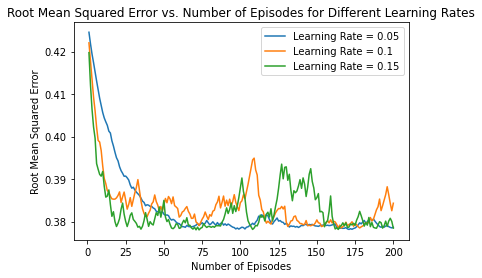

In [7]:
#Running experiments and plotting results
learning_rates = [0.05, 0.1, 0.15]  # List of learning rates to evaluate
num_episodes = 200  # Number of episodes per evaluation
true_state_values = np.arange(0, 7) / 6.0  # True state values

rmse_values = []  # List to store RMSE values for different learning rates

for learning_rate in learning_rates:
    value_history = TD_evaluation(learning_rate, num_episodes)  # Perform TD evaluation
    rmse = root_mean_squared_error(value_history, true_state_values)  # Calculate RMSE
    rmse_values.append(rmse)  # Store RMSE values

    # Plot RMSE over episodes for different learning rates
    plt.plot(range(1, num_episodes + 1), rmse, label=f'Learning Rate = {learning_rate}')

plt.xlabel('Number of Episodes')  # Set x-axis label
plt.ylabel('Root Mean Squared Error')  # Set y-axis label
plt.legend()  # Add legend to the plot
plt.title('Root Mean Squared Error vs. Number of Episodes for Different Learning Rates')  # Set the title
plt.show()  # Display the plot
print()  # Print a newline for formatting

In [8]:
def parameter_sweep_td(
    algorithm: Any,
    learning_rate_list: list,
    num_episodes: int,
    num_runs: int,
    true_state_values: np.ndarray,
) -> list:
    # Perform a parameter sweep for TD algorithm with different learning rates
    error_history = []  # List to store RMSE values for different learning rates
    value_history = np.zeros(shape=(num_runs, num_episodes, 5))  # Initialize value history

    for learning_rate in learning_rate_list:
        for i in range(num_runs):
            single_run_values = algorithm(learning_rate=learning_rate, num_episodes=num_episodes)
            value_history[i] = single_run_values[:, 1:-1]  # Store state values (excluding boundary states)

        rmse = root_mean_squared_error(value_history, true_state_values)  # Calculate RMSE
        error_history.append(rmse)  # Store RMSE values
    return error_history  # Return RMSE values for different learning rates

In [9]:
def td_algorithm_comparison(
    num_episodes: int, num_runs: int, true_state_values: np.ndarray
) -> None:
    # Compare TD learning with different learning rates
    learning_rate_list_td = [0.05, 0.1, (1/150)]  # List of TD learning rates
    colors = ["mediumseagreen", "steelblue", "orchid"]  # Define colors for plotting

    plt.figure(figsize=(9, 6), dpi=150)  # Create a figure for the plot
    plt.grid(c="lightgray")  # Add a grid to the plot
    plt.margins(0.02)  # Set margins
    for i, spine in enumerate(plt.gca().spines.values()):
        if i in [0, 2]:
            spine.set_linewidth(1.5)
            continue
        spine.set_visible(False)

    plt.xlabel("Walks/Episodes", fontdict={"fontsize": 11})  # Set x-axis label
    plt.ylabel("RMS Error", fontdict={"fontsize": 11})  # Set y-axis label

    # Loop through the learning rates and corresponding colors
    for learning_rate, color in zip(learning_rate_list_td, colors):
        td_error_history = parameter_sweep_td(
            TD_evaluation, [learning_rate], num_episodes, num_runs, true_state_values
        )[0]  # Get RMSE values for the current learning rate

        # Plot the curve with the current color
        plt.plot(
            td_error_history,
            c=color,
            label=f"TD Learning Rate $\\alpha$={learning_rate}",
        )

    plt.title(
        "Averaged Empirical RMS Error Over States for 100 Runs",
        fontsize=13,
        fontweight="bold",
    )  # Set the title
    plt.legend()  # Add legend to the plot
    plt.show()  # Display the plot
    print()  # Print a newline for formatting

In [10]:
# New function to plot the true values separately
def plot_true_values(true_state_values: np.ndarray) -> None:
    plt.figure(figsize=(9, 6), dpi=150)  # Create a figure for the plot
    plt.grid(c="lightgray")  # Add a grid to the plot
    plt.margins(0.02)  # Set margins
    for i, spine in enumerate(plt.gca().spines.values()):
        if i in [0, 2]:
            spine.set_linewidth(1.5)
            continue
        spine.set_visible(False)

    plt.xlabel("States", fontdict={"fontsize": 11})  # Set x-axis label
    plt.ylabel("True Values", fontdict={"fontsize": 11})  # Set y-axis label

    # Plot the true values as a horizontal line
    plt.plot(
        true_state_values,
        c="red",
        linestyle="--",
        marker="o",
        markersize=5,
        label="True Values",
    )

    plt.title("True Values of States", fontsize=13, fontweight="bold")  # Set the title
    plt.legend()  # Add legend to the plot
    plt.show()  # Display the plot
    print()  # Print a newline for formatting

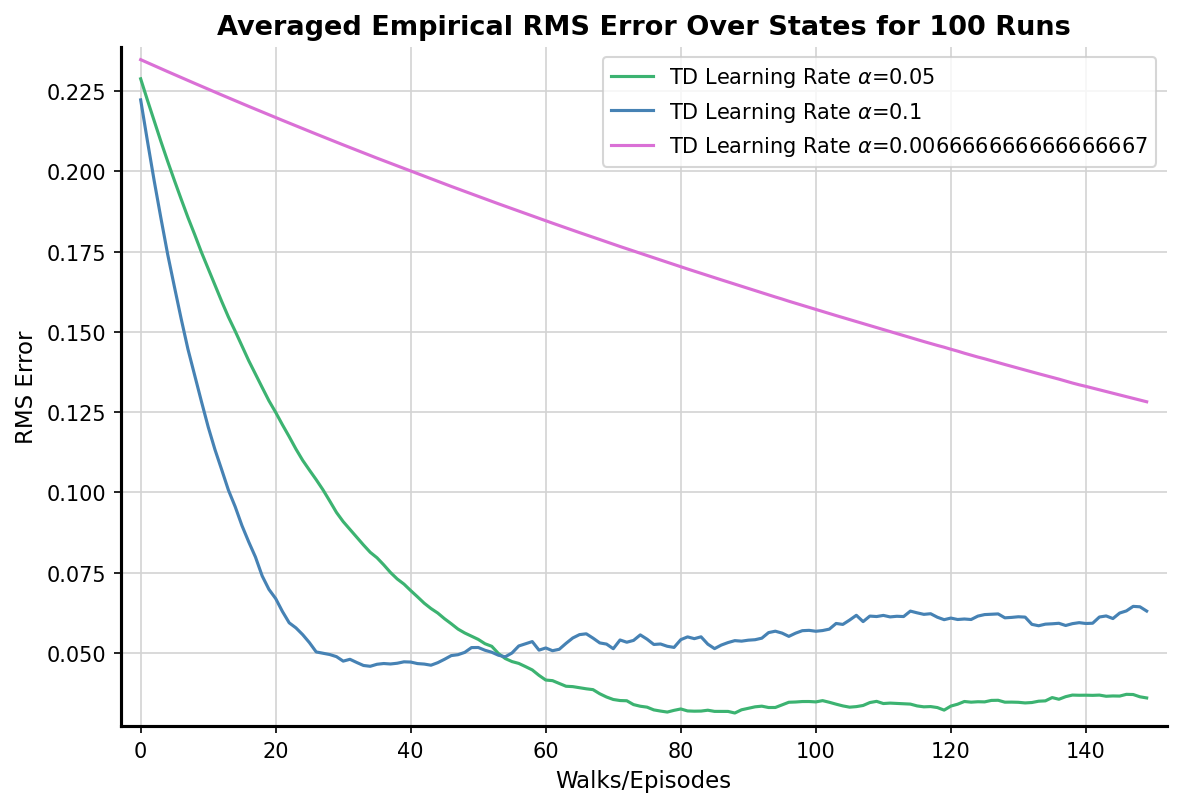

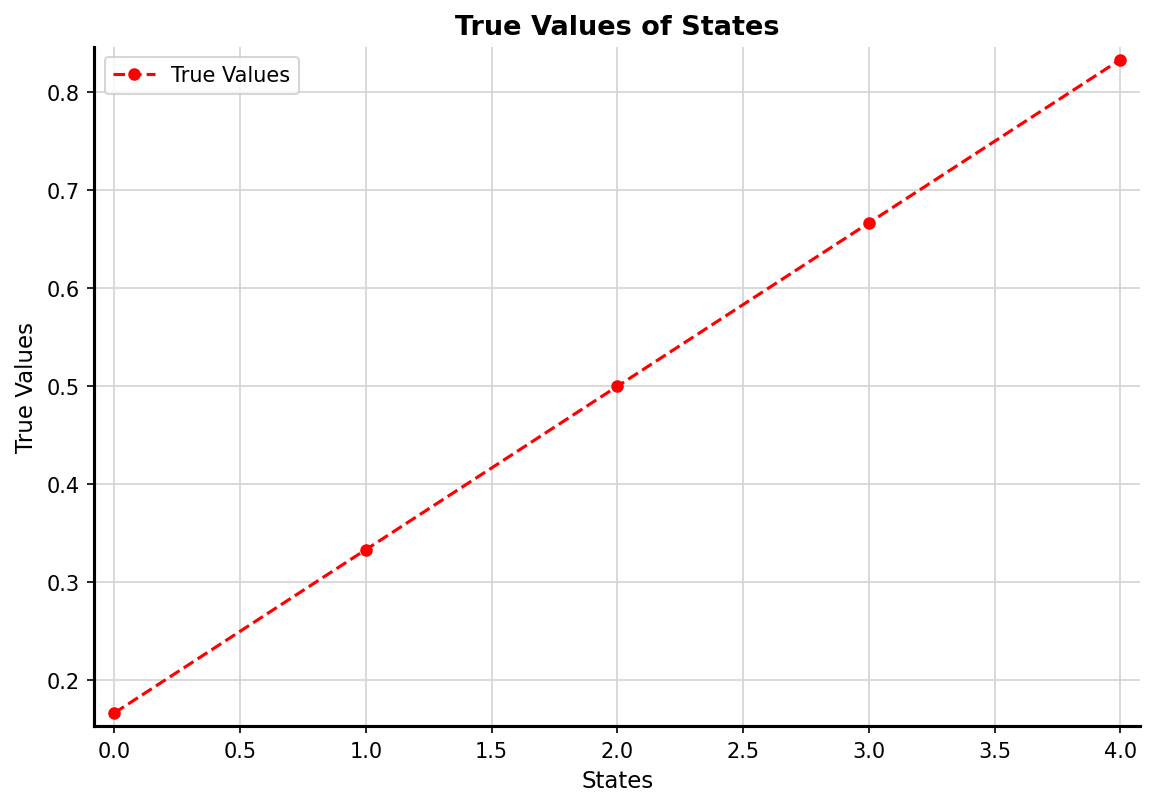

In [11]:
true_state_values = np.arange(0, 1.1, 1 / 6)[1:-1]  # True state values for the random walk
num_runs = 100  # Number of runs for parameter sweep
num_episodes = 150  # Number of episodes for each run

td_algorithm_comparison(num_episodes, num_runs, true_state_values)  # Compare TD algorithms
plot_true_values(true_state_values)  # Plot true state values